# Variational Auto-Encoders

In this exercise, I will try to build a Variational Auto-Encoder using PyTorch library. Next, VAE will be trained on MNIST dataset with a subsequent analysis of the results.

Special thanks to **Datacamp** website for their crash course on Pytorch.
Also to **Yandex Data Science School**, their Deep Learning course was helpful.
Finally, thanks to the **PyTorch development team** for this example: https://github.com/pytorch/examples/blob/master/vae/main.py

*Disclaimer*: VAE class implemented here is an almost identical copy of the VAE class that can be found by the link above. The main goal for me was to expand my knowledge of PyTorch, analyze an example of good usage of PyTorch and understand VAEs, and NOT to create an authentic piece of software.
# Table of contents <a name="toc"></a>
1. [Loading MNIST dataset](#getmnist)
2. [Creating VAE network](#makenet)
3. [Applying VAE to MNIST dataset](#applynet)
4. [Q/A session](#QA)  <br>
4.1. [Regarding activation functions](#q1)<br>
4.2. [Good recognition, but bad generation?](#q2)<br>
4.3. [Some experiments. Latent space. Recognition. Generation. Loss curve](#q3)<br>
4.4. [What is the relation between performance and latent space dimension?](#q5)<br>

In [1]:
# make necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image

## Load MNIST dataset <a name="getmnist"></a>
[to Table of contents](#toc)

In [2]:
# mean and std of the MNIST dataset (can be googled)
MNIST_mean = 0.1307
MNIST_std  = 0.3081

# batch size for an epoch of training, changeable
MNIST_batch_size = 128

MNIST_transform = transforms.Compose(
    [transforms.ToTensor()])

# prepare train and test sets
trainset = torchvision.datasets.MNIST("mnist", train=True, download=True, transform=MNIST_transform)
testset  = torchvision.datasets.MNIST("mnist", train=False, download=True, transform=MNIST_transform)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = MNIST_batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=MNIST_batch_size, shuffle=False)

## Creating VAE net <a name="makenet"></a>
[to Table of contents](#toc) <br>

In this section we will try and implement VAE using PyTorch. This section may be subject to future updates and experiments in order to improve performance.

In [3]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1  = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3  = nn.Linear(2, 400)
        self.fc4  = nn.Linear(400, 784)
    
    
    def encode(self, X):
        """
        encodes the inout image into two vectors: mean and variance
        :param X: input image in torch Tensor format
        :returns: mu and var
        """
        hidden1 = F.relu(self.fc1(X))
        return self.fc21(hidden1), self.fc22(hidden1)
    
    
    def reparameterize(self, mu, logvar):
        """
        implementation of the reparameterization trick, allowing for training with random sampling
        :param mu: mean values tensor
        :param var: logvariance tensor
        :returns: random tensor from the Gaussian distribution
        """
        # get variance
        std = torch.exp(0.5*logvar)
        
        # get random tensor from normal distribution of mean 0 and var 1 of size like std
        eps = torch.randn_like(std)
        return mu+eps*std
    
    
    def decode(self, z):
        """
        project a tensor from the latent space back into original coordinates
        :param z: tensor in the latent space to be decoded
        """
        hidden3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(hidden3))
    
    
    def forward(self, x):
        """
        forward function of VAE NN
        :param x: input image in torch Tensor format
        returns: x decoded from latent space along with mean and logvar tensors
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar 

In [4]:
#instantiate a model
model = VAE()

# instantiate an Adam optimizer with L2-regularization
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.001)

# define custom loss-function
def loss_func(reconstructed_x, x, mu, logvar):
    """
    defines a loss for our VAE. Consists of
    a) Reconstruction loss
    b) Kullback-Leibler divergence losses summed over all elements and the batch
    """

    reconstr_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstr_loss+KLd


def train_VAE(epoch):
    # put model in train mode
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        # zero all gradients
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = loss_func(reconstructed_batch, data, mu, logvar)
        
        # do backprop
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
def test_VAE(epoch):
    # put model into evaluation mode
    model.eval()
    test_loss = 0
    
    # deactivate autograd engine (backprop become unavailable, but that speeds up computations and
    # reduces memory usage; also, we don't update weights here, so backprop is not needed).
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
    test_loss /= len(testloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

## Applying VAE in MNIST dataset <a name="applynet"></a>
[to Table of contents](#toc)<br>

In this section we will experiment with VAE and use everything we prepared up until this point.

In [5]:
EPOCH_NUM = 5
for epoch in range(1, EPOCH_NUM + 1):
    train_VAE(epoch)
    test_VAE(epoch)
    with torch.no_grad():
        # let's try to decode a random vector from our latent space!
        sample = torch.randn(64, 2)
        sample = model.decode(sample)
        save_image(sample.view(64, 1, 28, 28),'results/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 191.0025
====> Test set loss: 169.5853
====> Epoch: 2 Average loss: 166.3231
====> Test set loss: 163.9559
====> Epoch: 3 Average loss: 162.5907
====> Test set loss: 161.8270
====> Epoch: 4 Average loss: 160.4590
====> Test set loss: 159.9381
====> Epoch: 5 Average loss: 158.9018
====> Test set loss: 158.4475


## Q/A session <a name="QA"></a>
[to Table of contents](#toc) <br>

In this section we will ponder some interesting questions about VAE and do a few experiments. Credits to [this article](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf) for a great intuitive explanation of VAEs. Before we begin, let's take a look at a diagram of our VAE.


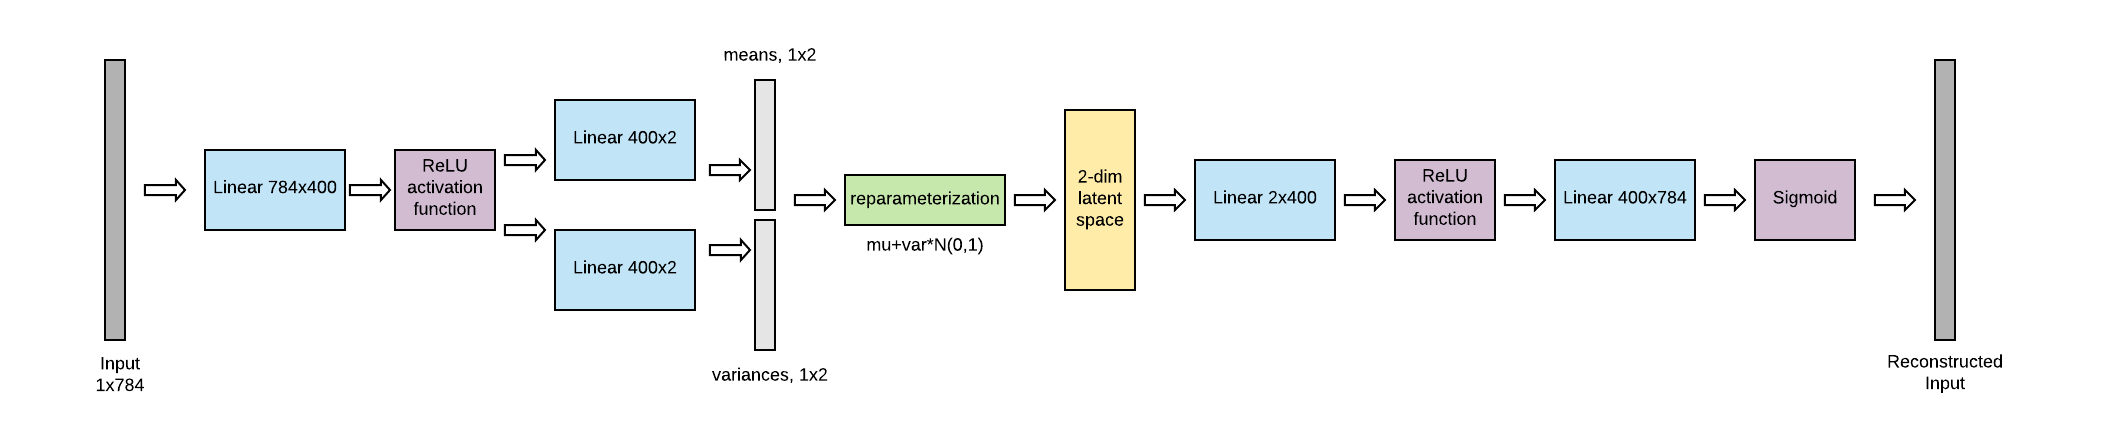

The first part of the network - encoder - is everything that comes before the latent 2D space. The second part - decoder - is everything that comes after. These parts are bascially symmetrical, except for the fact that in the encoder we generate two vectors before projecting them via reparameterization to the latent space, whereas in the decoder we sample directly.

We have used two activation functions: ReLU and Sigmoid. Let's discuss activation functions more in detail in the following question.

### 1. What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood—and why? <a name="q1"></a>
[to Table of contents](#toc)

Let's answer this question in parts. 
- Why use activation functions? Let us consider a Linear neuron. We can write its' output as: 
$$Y= \sum^{n}_{1}W*X + b$$
Therefore, in general, $Y$ can belong to $(-\infty, \infty)$, which is not good. Activation functions such as sigmoid or tanh limit the output of a neuron. 
Furthermore, activation functions introduce non-linearity to our neural network, enabling it to learn complex relationships between variables.

### 2. What might be the reason if we obtain good reconstructed but bad generated digits? <a name="q2"></a>
[to Table of contents](#toc)

An excellent answer to this question may be found in the article I [mentioned above](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf). All the images I present here are borrowed from there.
Here's what a standard autoencoder's latent space would look like after training: 

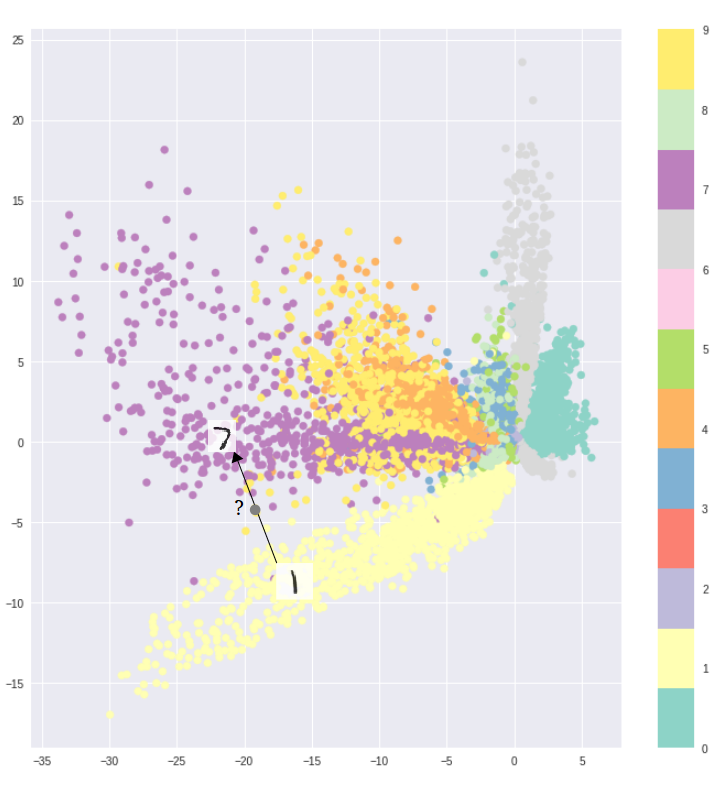

We notice that distinct clusters are formed. That is natural, because this makes it easier for the encoder to distinguish between digits while performing decoding. If our only goal was to recognize features, this would be fine. However, if we wish to *generate* new images, we encounter a problem. If we try to decode a vector from those huge gaps between clusters, we will get garbage, because decoder literally *sees such vectors for the first time*

This is why VAEs are nice. We introduce some uncertainty to our latent space by mapping input tensor not to a determenistic Z, but to a $\mu+\sigma*p$, where $p$ is drawn randomly from $N(0,1)$ This trick gets us something like this:

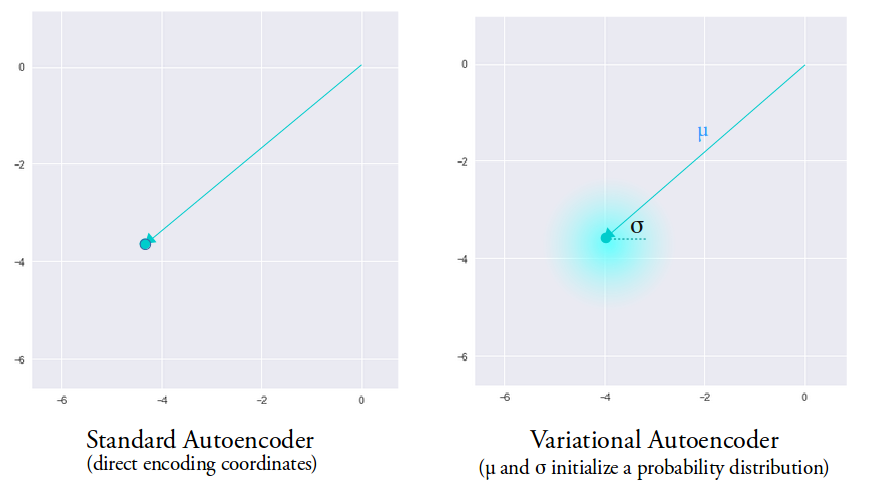

This is already looking good, but there is one more thing to consider - loss function. If we optimize only for reconstruction accuracy, we will end up with latent space looking like so (on the right):

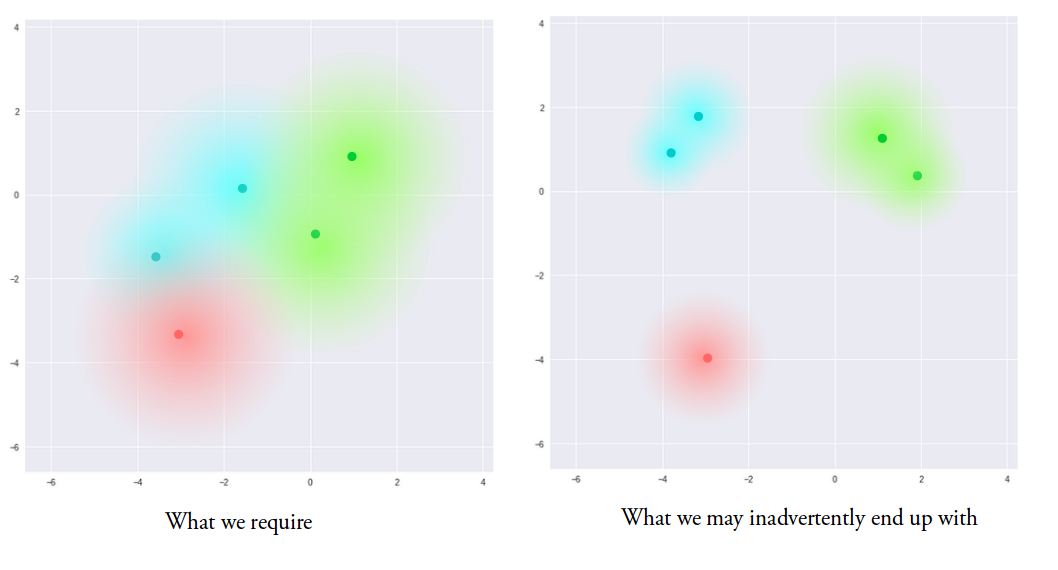

Even though this is better than standard auto-encoders, we still have this huge gaps between clusters. How could we bring this clusters closer together, so that when we sample tensors from latent space, we could get a reasonable output? By updating the loss function. We wish to penilize our VAE if it chooses to "cheat" and place clusters far away from each other in order to be able to easily recognize digits.

We do this by adding to reconstruction loss the Kullback-Leibler divergence between the real distribution of $z\in$ latent space and its approximation we chose to follow. For VAEs, the KL loss is equivalent to the sum of all the KL divergences between the component Xi~N(μi, σi²) in X, and the standard normal. It’s minimized when μi = 0, σi = 1.

Once we introduce KL divergence into our loss function, the latent space after training will look like this:

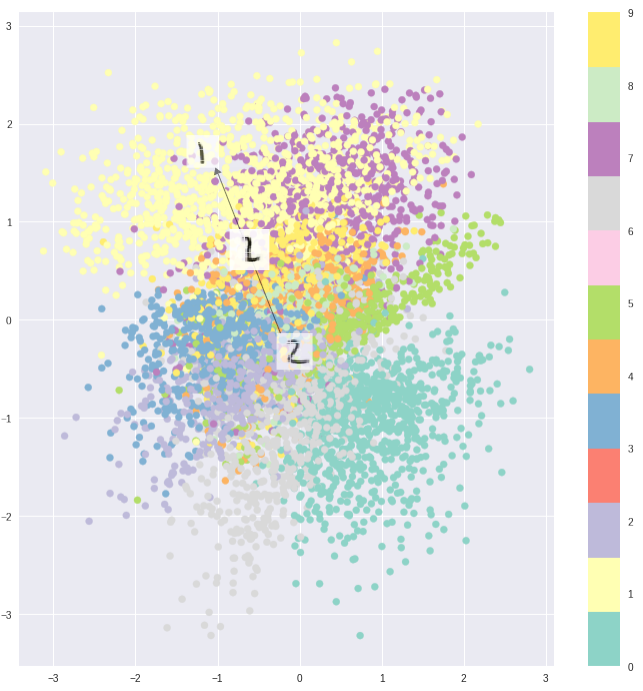

Now, when there are no gaps (almost) between clusters, we should be able to successfully sample the latent space and generate good output with our decoder.

Let's **sum up** - the reconstruction error part of the loss function is responsible for the *cluster-forming* nature of VAE, and KL divergence part - for stacking these clusters close together. Without KL divergence, we can recognize digits pretty well. However, generating new images will prove troublesome because of the huge gaps between clusters - if we try to decode a vector taken from there, decoder will not do well because it has never trained with such examples. 

Having said all this, we can now **answer the question**: if our VAE isn't good at generating new samples, it could be because clusters are not stacked close enough together, and, therefore, increasing weight of the KL divergence in the loss function could be the way to go.

### 3. A few experiments and visualizations with our VAE network (questions 3 and 4 of the task) <a name="q3"></a>
[go to Table of contents](#toc)

Here, we will take a look at how the system changes with number of epochs trained. At 5, 25 and 50 epochs we will plot:
 - latent space with visited points
 - 15 reconstructed digits alongside with 15 originals
 - 15 generated digits
 - dependency of loss function on epoch
 
For these purposes, we will alter our class a little.

In [1]:
# make necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import numpy as np

# batch size for an epoch of training, changeable
MNIST_batch_size = 128
MNIST_save_example_batch_size = 15

MNIST_transform = transforms.Compose(
    [transforms.ToTensor()])

# prepare train and test sets
trainset = torchvision.datasets.MNIST("mnist", train=True, download=True, transform=MNIST_transform)
testset  = torchvision.datasets.MNIST("mnist", train=False, download=True, transform=MNIST_transform)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = MNIST_batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=MNIST_batch_size, shuffle=False)

save15loader = torch.utils.data.DataLoader(testset, batch_size=MNIST_save_example_batch_size, shuffle=False)

In [2]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1  = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2)
        self.fc22 = nn.Linear(400, 2)
        self.fc3  = nn.Linear(2, 400)
        self.fc4  = nn.Linear(400, 784)
        self.latent_points=np.array([[-100, -100]])
        self.list_labels = np.array([0])
        self.loss_vals = np.array([0])
        self.epoch_vals = np.array([0])

    def encode(self, X):
        """
        encodes the inout image into two vectors: mean and variance
        :param X: input image in torch Tensor format
        :returns: mu and var
        """
        hidden1 = F.relu(self.fc1(X))
        return self.fc21(hidden1), self.fc22(hidden1)
    
    
    def reparameterize(self, mu, logvar):
        """
        implementation of the reparameterization trick, allowing for training with random sampling
        :param mu: mean values tensor
        :param var: logvariance tensor
        :returns: random tensor from the Gaussian distribution
        """
        # get variance
        std = torch.exp(0.5*logvar)
        
        # get random tensor from normal distribution of mean 0 and var 1 of size like std
        eps = torch.randn_like(std)
        if self.training == True:
            self.latent_points = np.concatenate((self.latent_points, (mu+eps*std).detach().numpy()), axis=0)
        return mu+eps*std
    
    
    def decode(self, z):
        """
        project a tensor from the latent space back into original coordinates
        :param z: tensor in the latent space to be decoded
        """
        hidden3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(hidden3))
    
    
    def forward(self, x):
        """
        forward function of VAE NN
        :param x: input image in torch Tensor format
        returns: x decoded from latent space along with mean and logvar tensors
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar         

In [3]:
#instantiate a model
model = VAE()

# instantiate an Adam optimizer with L2-regularization
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.001)

# define custom loss-function
def loss_func(reconstructed_x, x, mu, logvar):
    """
    defines a loss for our VAE. Consists of
    a) Reconstruction loss
    b) Kullback-Leibler divergence losses summed over all elements and the batch
    """

    reconstr_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstr_loss+KLd


def train_VAE(epoch):
    # put model in train mode
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(trainloader):
        # zero all gradients
        model.list_labels = np.concatenate((model.list_labels, labels.numpy().ravel()))
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = loss_func(reconstructed_batch, data, mu, logvar)
        
        # do backprop
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
def test_VAE(epoch):
    # put model into evaluation mode
    model.eval()
    test_loss = 0
    
    # deactivate autograd engine (backprop become unavailable, but that speeds up computations and
    # reduces memory usage; also, we don't update weights here, so backprop is not needed).
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
    test_loss /= len(testloader.dataset)
    model.loss_vals = np.concatenate((model.loss_vals, np.array([test_loss])))
    model.epoch_vals = np.concatenate((model.epoch_vals, np.array([epoch])))
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

def visualize_batch(epoch):
    reset = False
    if model.training:
        model.eval()
        reset = True
    for i, (data, labels) in enumerate(save15loader):
        recon_batch, mu, logvar = model(data)
        save_image(data.view(MNIST_save_example_batch_size, 1, 28, 28),'results_encdec/data_' + str(epoch) + '.png')
        save_image(recon_batch.view(MNIST_save_example_batch_size, 1, 28, 28),'results_encdec/reconstr_' + str(epoch) + '.png')
        break
    if reset:
        model.train()
    return

====> Epoch: 1 Average loss: 191.3973
====> Test set loss: 171.3022
====> Epoch: 2 Average loss: 167.7165
====> Test set loss: 165.2955
====> Epoch: 3 Average loss: 163.7736
====> Test set loss: 162.1199
====> Epoch: 4 Average loss: 161.2509
====> Test set loss: 160.1998
====> Epoch: 5 Average loss: 159.4107
====> Test set loss: 158.5743
====> Epoch: 6 Average loss: 158.0167
====> Test set loss: 157.3363
====> Epoch: 7 Average loss: 156.9334
====> Test set loss: 156.7388
====> Epoch: 8 Average loss: 156.0831
====> Test set loss: 155.8548
====> Epoch: 9 Average loss: 155.3243
====> Test set loss: 155.4919
====> Epoch: 10 Average loss: 154.6556
====> Test set loss: 155.0914
====> Epoch: 11 Average loss: 154.0475
====> Test set loss: 154.7382
====> Epoch: 12 Average loss: 153.5562
====> Test set loss: 153.8639
====> Epoch: 13 Average loss: 153.0426
====> Test set loss: 153.4091
====> Epoch: 14 Average loss: 152.6704
====> Test set loss: 153.6284
====> Epoch: 15 Average loss: 152.2564
====

<Figure size 720x2880 with 0 Axes>

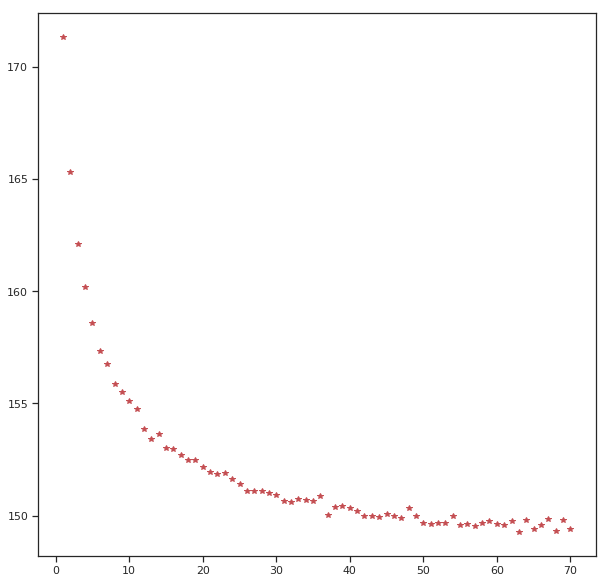

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn
seaborn.set(style='ticks')

fig = plt.figure(figsize=(10,40))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[1, 1, 1, 1])

EPOCH_NUM = 70
for epoch in range(1, EPOCH_NUM + 1):
    train_VAE(epoch)
    if epoch in [5, 25, 50, 70]:
        
        # plot latent space
        vis_df = pd.DataFrame({"label": model.list_labels, "x": model.latent_points[:, 0], "y": model.latent_points[:,1]})
        vis_df = vis_df.loc[vis_df.x != -100] #sorry :)
        categories = np.unique(vis_df["label"])
        colors = np.linspace(0, 1, len(categories))
        colordict = dict(zip(categories, colors))
        vis_df["Color"] = vis_df["label"].apply(lambda x: colordict[x])
        ax0 = fig.add_subplot(gs[[5, 25, 50, 70].index(epoch),0])
        ax0.scatter(vis_df["x"], vis_df["y"], c=vis_df.Color)
        ax0.set_title("Latent space for epoch " + str(epoch))
        
        #plot 15 digits vs their reconstructions
        visualize_batch(epoch)
        
        # generate 15 new digits
        with torch.no_grad():
            # let's try to decode a random vector from our latent space!
            sample = torch.randn(15, 2)
            sample = model.decode(sample)
            save_image(sample.view(15, 1, 28, 28),'results_gen/sample_' + str(epoch) + '.png')
    test_VAE(epoch)
plt.savefig("results_latent/ls_epochnum_"+str(EPOCH_NUM)+".png")
plt.clf()
fig1 = plt.figure(figsize=(10,10))
plt.plot(model.epoch_vals.ravel()[1:], model.loss_vals.ravel()[1:], "*r" )
plt.savefig("results_loss/loss_curve.png")


### Comparing performances for identical VAEs with different latent space dimensions (question 5) <a name="q5"></a>
[go to Table of Contents](#toc)

Here we will see what role does the dimension of the latent space play. Intuitively, higher dimension allow for higher information preservation, so the the network should be able to produce better results. But let us check this intuition on practice.

Code below is a copy-paste of the previous class with Linear node dims changed. 

In [12]:
# make necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import numpy as np

# batch size for an epoch of training, changeable
MNIST_batch_size = 128
MNIST_save_example_batch_size = 15

MNIST_transform = transforms.Compose(
    [transforms.ToTensor()])

# prepare train and test sets
trainset = torchvision.datasets.MNIST("mnist", train=True, download=True, transform=MNIST_transform)
testset  = torchvision.datasets.MNIST("mnist", train=False, download=True, transform=MNIST_transform)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = MNIST_batch_size, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=MNIST_batch_size, shuffle=False)

save15loader = torch.utils.data.DataLoader(testset, batch_size=MNIST_save_example_batch_size, shuffle=False)

In [13]:
class VAE32(nn.Module):
    def __init__(self):
        super(VAE32, self).__init__()
        
        self.fc1  = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 32)
        self.fc22 = nn.Linear(400, 32)
        self.fc3  = nn.Linear(32, 400)
        self.fc4  = nn.Linear(400, 784)
        self.loss_vals = np.array([0])
        self.epoch_vals = np.array([0])

    def encode(self, X):
        """
        encodes the inout image into two vectors: mean and variance
        :param X: input image in torch Tensor format
        :returns: mu and var
        """
        hidden1 = F.relu(self.fc1(X))
        return self.fc21(hidden1), self.fc22(hidden1)
    
    
    def reparameterize(self, mu, logvar):
        """
        implementation of the reparameterization trick, allowing for training with random sampling
        :param mu: mean values tensor
        :param var: logvariance tensor
        :returns: random tensor from the Gaussian distribution
        """
        # get variance
        std = torch.exp(0.5*logvar)
        
        # get random tensor from normal distribution of mean 0 and var 1 of size like std
        eps = torch.randn_like(std)
        return mu+eps*std
    
    
    def decode(self, z):
        """
        project a tensor from the latent space back into original coordinates
        :param z: tensor in the latent space to be decoded
        """
        hidden3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(hidden3))
    
    
    def forward(self, x):
        """
        forward function of VAE NN
        :param x: input image in torch Tensor format
        returns: x decoded from latent space along with mean and logvar tensors
        """
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar         

In [14]:
#instantiate a model
model = VAE32()

# instantiate an Adam optimizer with L2-regularization
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.001)

# define custom loss-function
def loss_func(reconstructed_x, x, mu, logvar):
    """
    defines a loss for our VAE. Consists of
    a) Reconstruction loss
    b) Kullback-Leibler divergence losses summed over all elements and the batch
    """

    reconstr_loss = F.binary_cross_entropy(reconstructed_x, x.view(-1, 784), reduction='sum')
    KLd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstr_loss+KLd


def train_VAE(epoch):
    # put model in train mode
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(trainloader):
        # zero all gradients
        optimizer.zero_grad()
        reconstructed_batch, mu, logvar = model(data)
        loss = loss_func(reconstructed_batch, data, mu, logvar)
        
        # do backprop
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(trainloader.dataset)))
    
def test_VAE(epoch):
    # put model into evaluation mode
    model.eval()
    test_loss = 0
    
    # deactivate autograd engine (backprop become unavailable, but that speeds up computations and
    # reduces memory usage; also, we don't update weights here, so backprop is not needed).
    with torch.no_grad():
        for i, (data, _) in enumerate(testloader):
            recon_batch, mu, logvar = model(data)
            test_loss += loss_func(recon_batch, data, mu, logvar).item()
    test_loss /= len(testloader.dataset)
    model.loss_vals = np.concatenate((model.loss_vals, np.array([test_loss])))
    model.epoch_vals = np.concatenate((model.epoch_vals, np.array([epoch])))
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

def visualize_batch(epoch):
    reset = False
    if model.training:
        model.eval()
        reset = True
    for i, (data, labels) in enumerate(save15loader):
        recon_batch, mu, logvar = model(data)
        save_image(data.view(MNIST_save_example_batch_size, 1, 28, 28),'results_encdec/data_' + str(epoch) + '.png')
        save_image(recon_batch.view(MNIST_save_example_batch_size, 1, 28, 28),'results_encdec/reconstr_' + str(epoch) + '.png')
        break
    if reset:
        model.train()
    return

====> Epoch: 1 Average loss: 168.3487
====> Test set loss: 131.4036
====> Epoch: 2 Average loss: 124.5914
====> Test set loss: 117.8477
====> Epoch: 3 Average loss: 116.0906
====> Test set loss: 113.0295
====> Epoch: 4 Average loss: 112.4103
====> Test set loss: 110.4050
====> Epoch: 5 Average loss: 110.3089
====> Test set loss: 108.8667
====> Epoch: 6 Average loss: 108.9923
====> Test set loss: 107.7283
====> Epoch: 7 Average loss: 108.0306
====> Test set loss: 107.0760
====> Epoch: 8 Average loss: 107.2828
====> Test set loss: 106.5496
====> Epoch: 9 Average loss: 106.7210
====> Test set loss: 105.8571
====> Epoch: 10 Average loss: 106.3206
====> Test set loss: 105.7937
====> Epoch: 11 Average loss: 105.9657
====> Test set loss: 105.2165
====> Epoch: 12 Average loss: 105.6112
====> Test set loss: 104.9035
====> Epoch: 13 Average loss: 105.3288
====> Test set loss: 104.6346
====> Epoch: 14 Average loss: 105.0917
====> Test set loss: 104.6252
====> Epoch: 15 Average loss: 104.8820
====

<Figure size 720x2880 with 0 Axes>

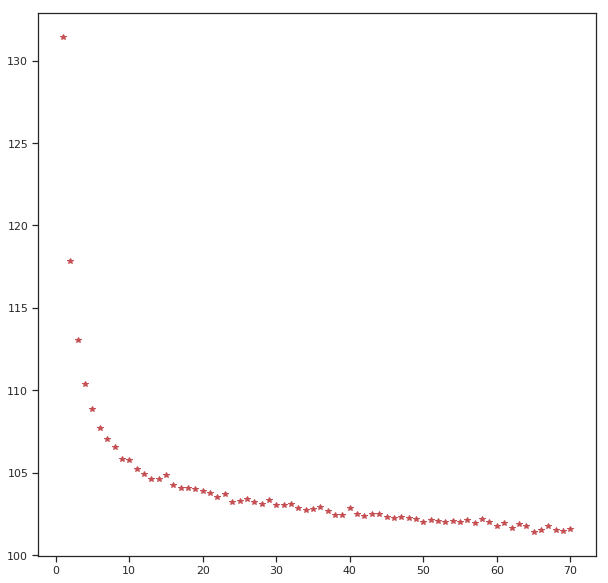

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn
seaborn.set(style='ticks')

fig = plt.figure(figsize=(10,40))
gs = gridspec.GridSpec(nrows=4, ncols=1, height_ratios=[1, 1, 1, 1])

EPOCH_NUM = 70
for epoch in range(1, EPOCH_NUM + 1):
    train_VAE(epoch)
    if epoch in [5, 25, 50, 70]:        
        #plot 15 digits vs their reconstructions
        visualize_batch(epoch)
        
        # generate 15 new digits
        with torch.no_grad():
            # let's try to decode a random vector from our latent space!
            sample = torch.randn(15, 32)
            sample = model.decode(sample)
            save_image(sample.view(15, 1, 28, 28),'results_gen32/sample_' + str(epoch) + '.png')
    test_VAE(epoch)
plt.clf()
fig1 = plt.figure(figsize=(10,10))
plt.plot(model.epoch_vals.ravel()[1:], model.loss_vals.ravel()[1:], "*r" )
plt.savefig("results_loss32/loss_curve.png")

So, let us compare the loss functions of these two neural networks. First, loss for a VAE with 2-dimensional latent space.

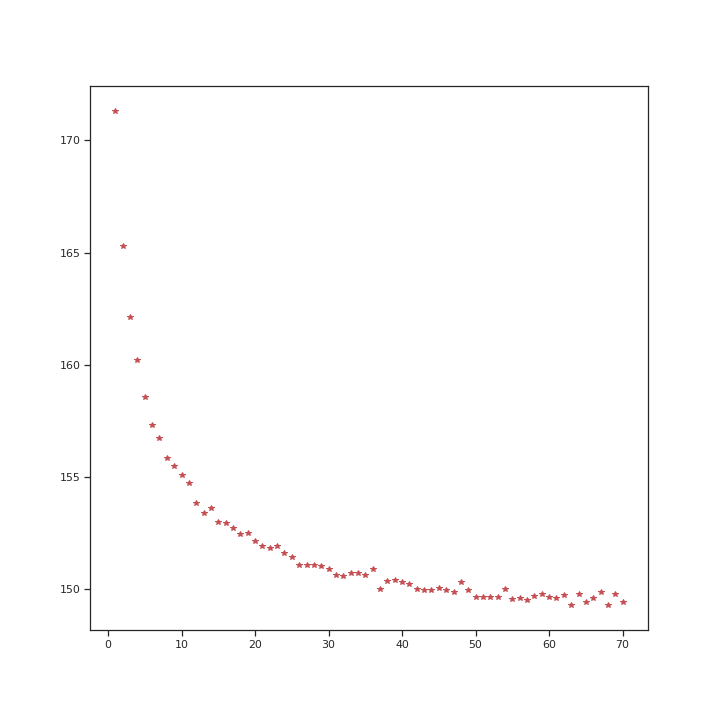

Oops, sorry for not signing the axes. X is epochs, Y is loss. 

So, after 70 epochs, loss went down to about 150 and started oscillating there. How about a more complex 32-dimensional latent space?

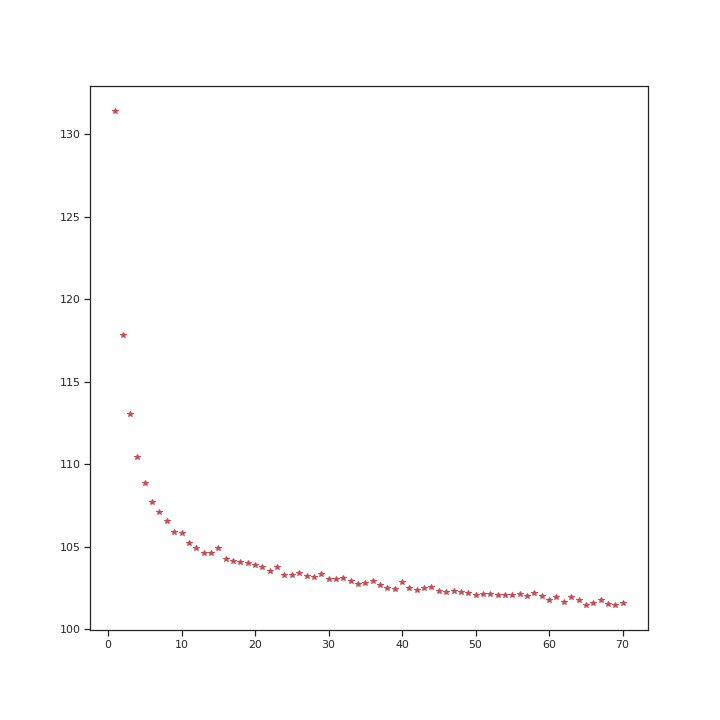

We see that our intuition was correct. 32-dimensional space captures more information and allows for a better restoration of the image. The new loss after 70 epochs is only about 2/3 of the previous one. 

But what about image generation? Let's take a look. Here's what we get with 2-dimensional latent space:

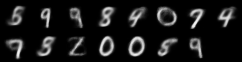

Not bad! Digits are recognizable, Kullback-Leibler has clearly done the job, we got sufficiently dense classes and were able to decode randomly-sampled vectors from our latent space. Let's move on to 32-dimensional VAE results.

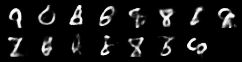

Ew. That is actually pretty bad, huh? Now, why might that be? Isn't this VAE supposed to be more powerful than the previous one? 

Yes, it is - when it comes to image recognition. I think that the problem with generating new images lies within the same realm as does the Curse of dimensionality. The more dimensions we have, the harder it is to describe it and the more data we need to cover it. 32 dimensions is way more than 2! Therefore, we need way more data to cover it with sufficient density and therefore be able to randomly sample it and generat new pretty images. MNIST seems to be too small for this kind of dimensions. 

We have a sort of a tradeoff here - better restoration for worse generation. 